In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
df = pd.read_csv("netflix.csv")
closed_prices = df["Close"]

In [3]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,23-05-2002,1.242857,1.145714,1.156429,1.196429,104790000,1.196429
1,24-05-2002,1.225000,1.197143,1.214286,1.210000,11104800,1.210000
2,28-05-2002,1.232143,1.157143,1.213571,1.157143,6609400,1.157143
3,29-05-2002,1.164286,1.085714,1.164286,1.103571,6757800,1.103571
4,30-05-2002,1.107857,1.071429,1.107857,1.071429,10154200,1.071429


In [4]:
df.shape

(4881, 7)

In [7]:
mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[..., None]).squeeze()
seq_len=15

In [8]:
X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i: i + seq_len])
    y.append(scaled_price[i + seq_len])

X = np.array(X)[..., None]
y = np.array(y)[..., None]

train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

In [9]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        return self.fc(hidden[-1, :])

In [10]:
model = Model(1, 64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [11]:
num_epochs = 100

for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output, train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 and epoch != 0:
        print(epoch, "epoch loss", loss.detach().numpy())


10 epoch loss 0.0058433376
20 epoch loss 0.0046476745
30 epoch loss 0.0040973504
40 epoch loss 0.0034291344
50 epoch loss 0.00216675
60 epoch loss 8.4150335e-05
70 epoch loss 6.762153e-05
80 epoch loss 0.00010075637
90 epoch loss 7.2336705e-05


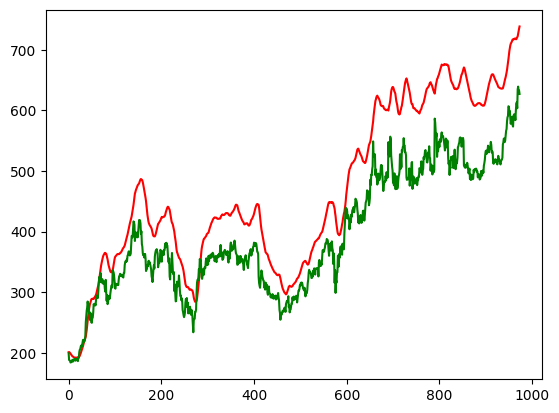

In [12]:
model.eval()
with torch.no_grad():
    output = model(test_x)

pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())

plt.plot(pred.squeeze(), color="red", label="predicted")
plt.plot(real.squeeze(), color="green", label="real")
plt.show()
